<a href="https://colab.research.google.com/github/CALDISS-AAU/sdsphd20/blob/master/notebooks/thu26/Fast_AI_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai import *
from fastai.text import *
import pandas as pd

In [ ]:
data = pd.read_csv("https://github.com/CALDISS-AAU/sdsphd20/raw/master/datasets/imdb.zip", sep="\t")

In [ ]:
sub_df = data.copy()

In [ ]:
sub_df

,is_positive,review
0,0,"Dreamgirls, despite its fistful of Tony wins i..."
1,0,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...
3,0,Spoilers ahead if you want to call them that.....
4,1,My all-time favorite movie! I have seen many m...
...,...,...
24995,1,"I am a big fan of the movie, but not for the u..."
24996,0,I'm not going to bother with a plot synopsis s...
24997,0,This movie . . . I don't know. Why they would ...
24998,1,Saw this film on DVD yesterday and was gob-sma...


In [ ]:
sub_df.rename(columns={'is_positive': 'label' , 'review' : 'text'}, inplace=True)
sub_df.head(5)

,label,text
0,0,"Dreamgirls, despite its fistful of Tony wins i..."
1,0,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...
3,0,Spoilers ahead if you want to call them that.....
4,1,My all-time favorite movie! I have seen many m...


In [ ]:
# split data into training validation set
from sklearn.model_selection import train_test_split

sub_df_trn, sub_df_val = train_test_split(sub_df, stratify = sub_df['label'], test_size = 0.4, random_state = 12)

In [ ]:
sub_df_trn.shape, sub_df_val.shape


((15000, 2), (10000, 2))

In [ ]:
# Train language model
data_lm = TextLMDataBunch.from_df(train_df = sub_df_trn, valid_df = sub_df_val, path = "")

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.252490,4.005153,0.291641,06:10


In [ ]:
learn.save_encoder('ft_enc')

In [ ]:
# Build classifier
data_clas = TextClasDataBunch.from_df(train_df = sub_df_trn, valid_df = sub_df_val, path=".", vocab=data_lm.train_ds.vocab, bs=32)

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (15000 items)
x: TextList
xxbos i gave this film an 10 / 10 with some reluctance as it 's hard to praise something that so haunted and terrified me for years . xxmaj the sheer menace on the woman in black 's face is just pure horror and the accompanying music just worsens the dread . 
 
  i saw this when it was first on xxup tv when i was 10 and it really did disturb me for years . i 'm fascinated by the fact that so many other users have said this too . xxmaj so many movie reviews go on about how disturbing or terrifying a film might be but you can believe all those who have posted on this board , this really is incredibly powerful stuff . i mean i really like horror films and generally find them quite funny more often than not , but this really is menacing and will probably disturb most people . i have n't seen it since i was 10 and i 'm tempted to watch it again but fear i might have some sleepless nights . i ca n't quite put my f

In [ ]:
# train final layers
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.436485,0.344233,0.857400,02:14


In [ ]:
# unfreeze model and fine tune it
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.346651,0.253466,0.895800,03:01


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.283231,0.215611,0.914100,05:16


In [ ]:
# unfreeze model and fine tune it
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-3/2., 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.261427,0.198386,0.920400,04:03


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3/100, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.212364,0.189218,0.925900,04:38


In [ ]:
from fastai.vision import *
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

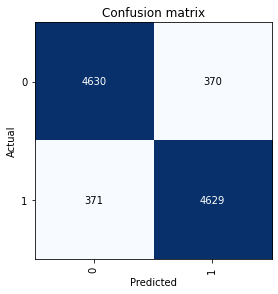

In [ ]:
interp.plot_confusion_matrix()